# Data Loading and Exploration

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

In [2]:
# Load data
train_data = pd.read_csv('Training.csv')
test_data = pd.read_csv('Testing.csv')

In [3]:
# Display first few rows
train_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


# Data Preprocessing

In [4]:
# Check for missing values
print(train_data.isnull().sum())

itching                    0
skin_rash                  0
nodal_skin_eruptions       0
continuous_sneezing        0
shivering                  0
                        ... 
blister                    0
red_sore_around_nose       0
yellow_crust_ooze          0
prognosis                  0
Unnamed: 133            4920
Length: 134, dtype: int64


In [5]:
# Handle missing values by dropping columns with NaN (if necessary)
train_data = train_data.drop(columns=['Unnamed: 133'])

In [6]:
# Encode target labels
le = LabelEncoder()
train_data['prognosis'] = le.fit_transform(train_data['prognosis'])
test_data['prognosis'] = le.transform(test_data['prognosis'])

In [7]:
# Split features and labels
X_train = train_data.drop(columns=['prognosis'])
y_train = train_data['prognosis']
X_test = test_data.drop(columns=['prognosis'])
y_test = test_data['prognosis']

# Model Selection and Training

In [8]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Define the pipeline with preprocessing and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   # Handle missing values
    ('scaler', StandardScaler()),                  # Feature scaling
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

In [10]:
# Hyperparameter grid to search
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

In [11]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             verbose=2)

In [12]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

In [13]:
# Evaluate the model on validation data
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

Validation Accuracy: 1.0000
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Common Cold       1.00      1.00      1.00        23

# Visualizations

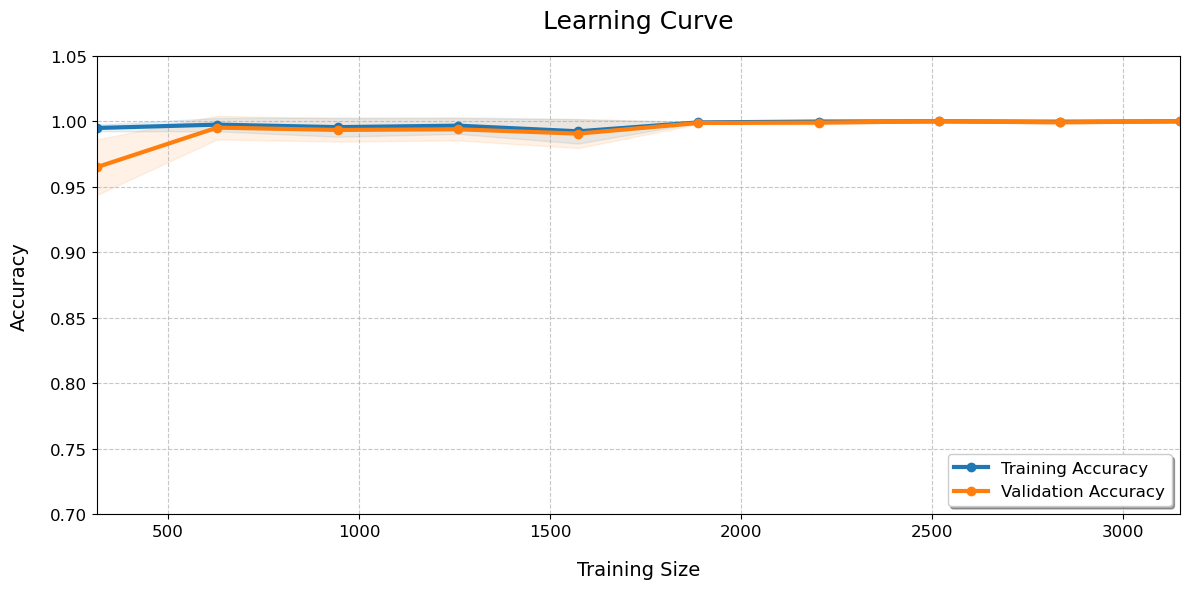

In [14]:
from sklearn.model_selection import learning_curve

# Calculate the learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='#1f77b4', label='Training Accuracy', linewidth=3)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='#1f77b4', alpha=0.1)

plt.plot(train_sizes, val_scores_mean, 'o-', color='#ff7f0e', label='Validation Accuracy', linewidth=3)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color='#ff7f0e', alpha=0.1)

# Customize the plot's appearance
plt.xlabel('Training Size', fontsize=14, labelpad=15)
plt.ylabel('Accuracy', fontsize=14, labelpad=15)
plt.title('Learning Curve', fontsize=18, pad=20)

# Enhance the legend
plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x and y axis limits
plt.xlim([train_sizes[0], train_sizes[-1]])
plt.ylim([0.7, 1.05])

# Add ticks with a modern style
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Finalize and display the plot
plt.tight_layout()
plt.show()


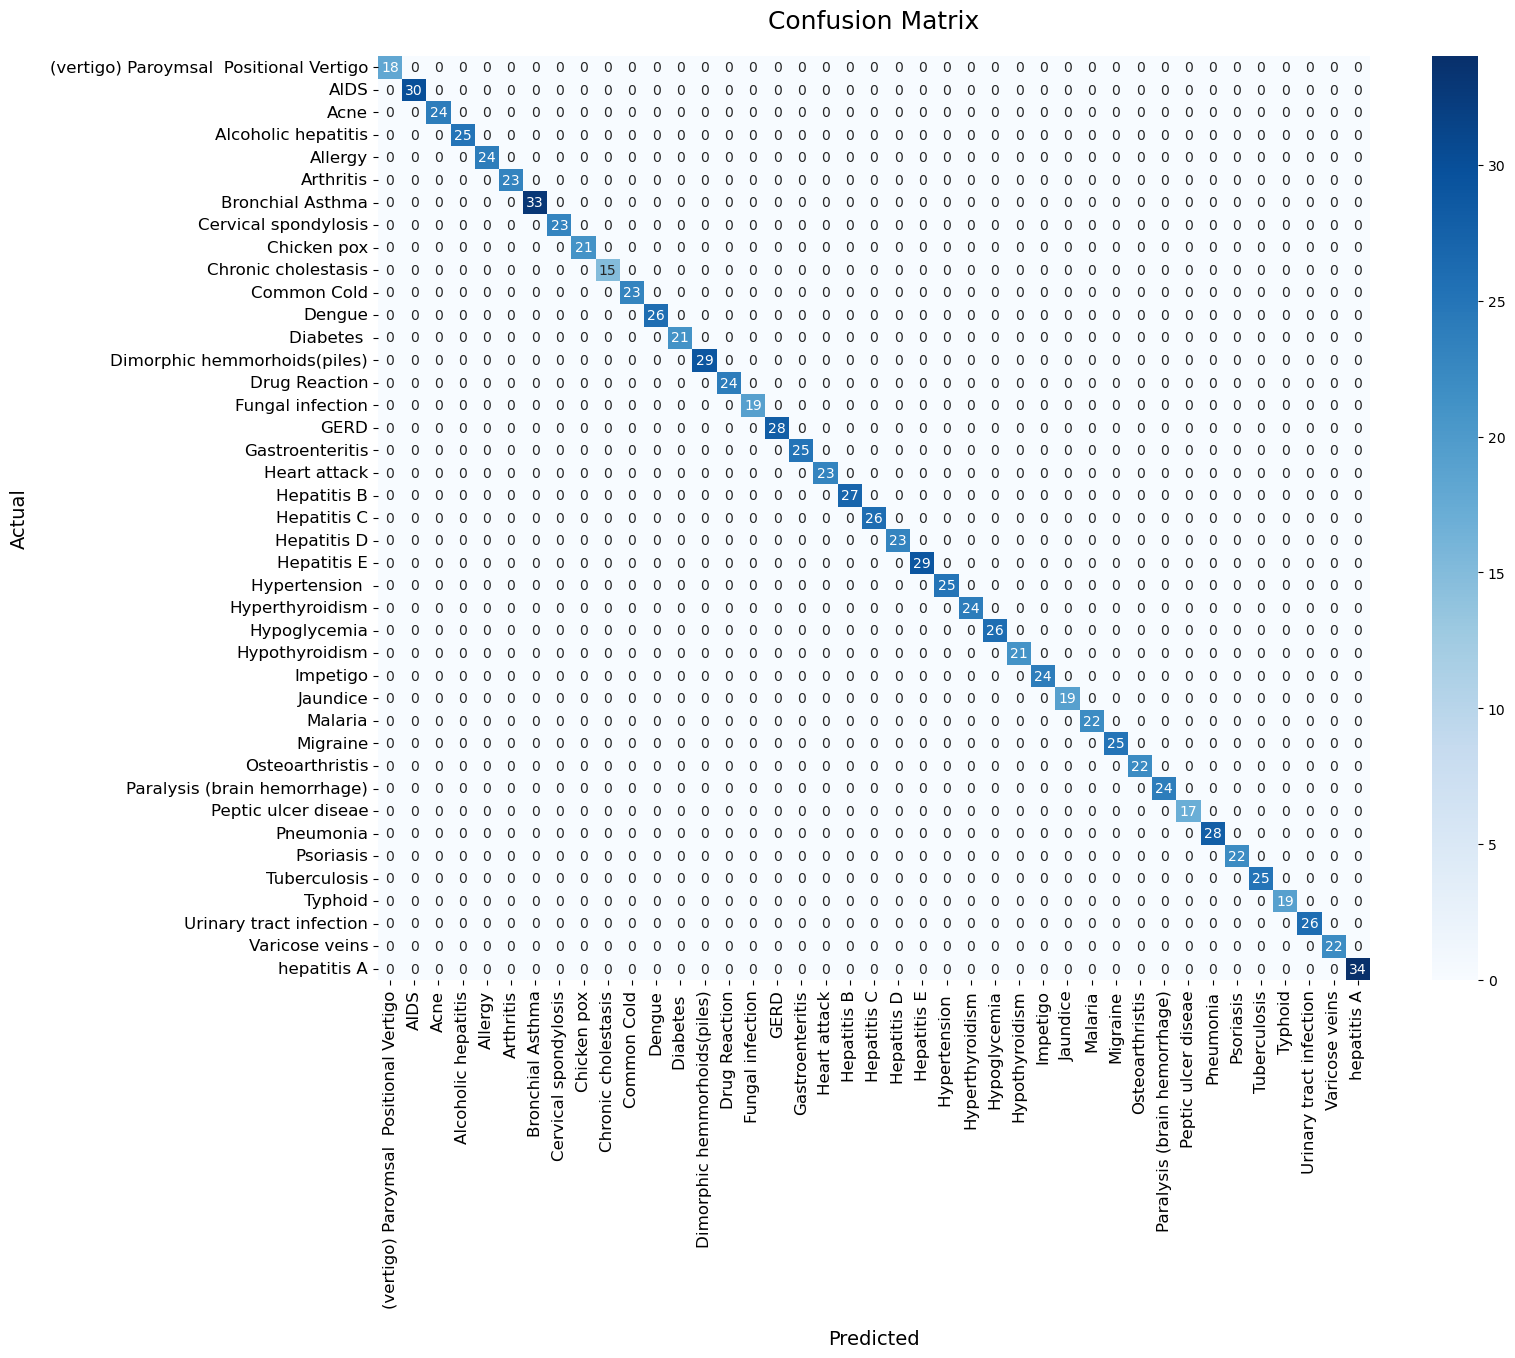

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.xlabel('Predicted', fontsize=14, labelpad=15)
plt.ylabel('Actual', fontsize=14, labelpad=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

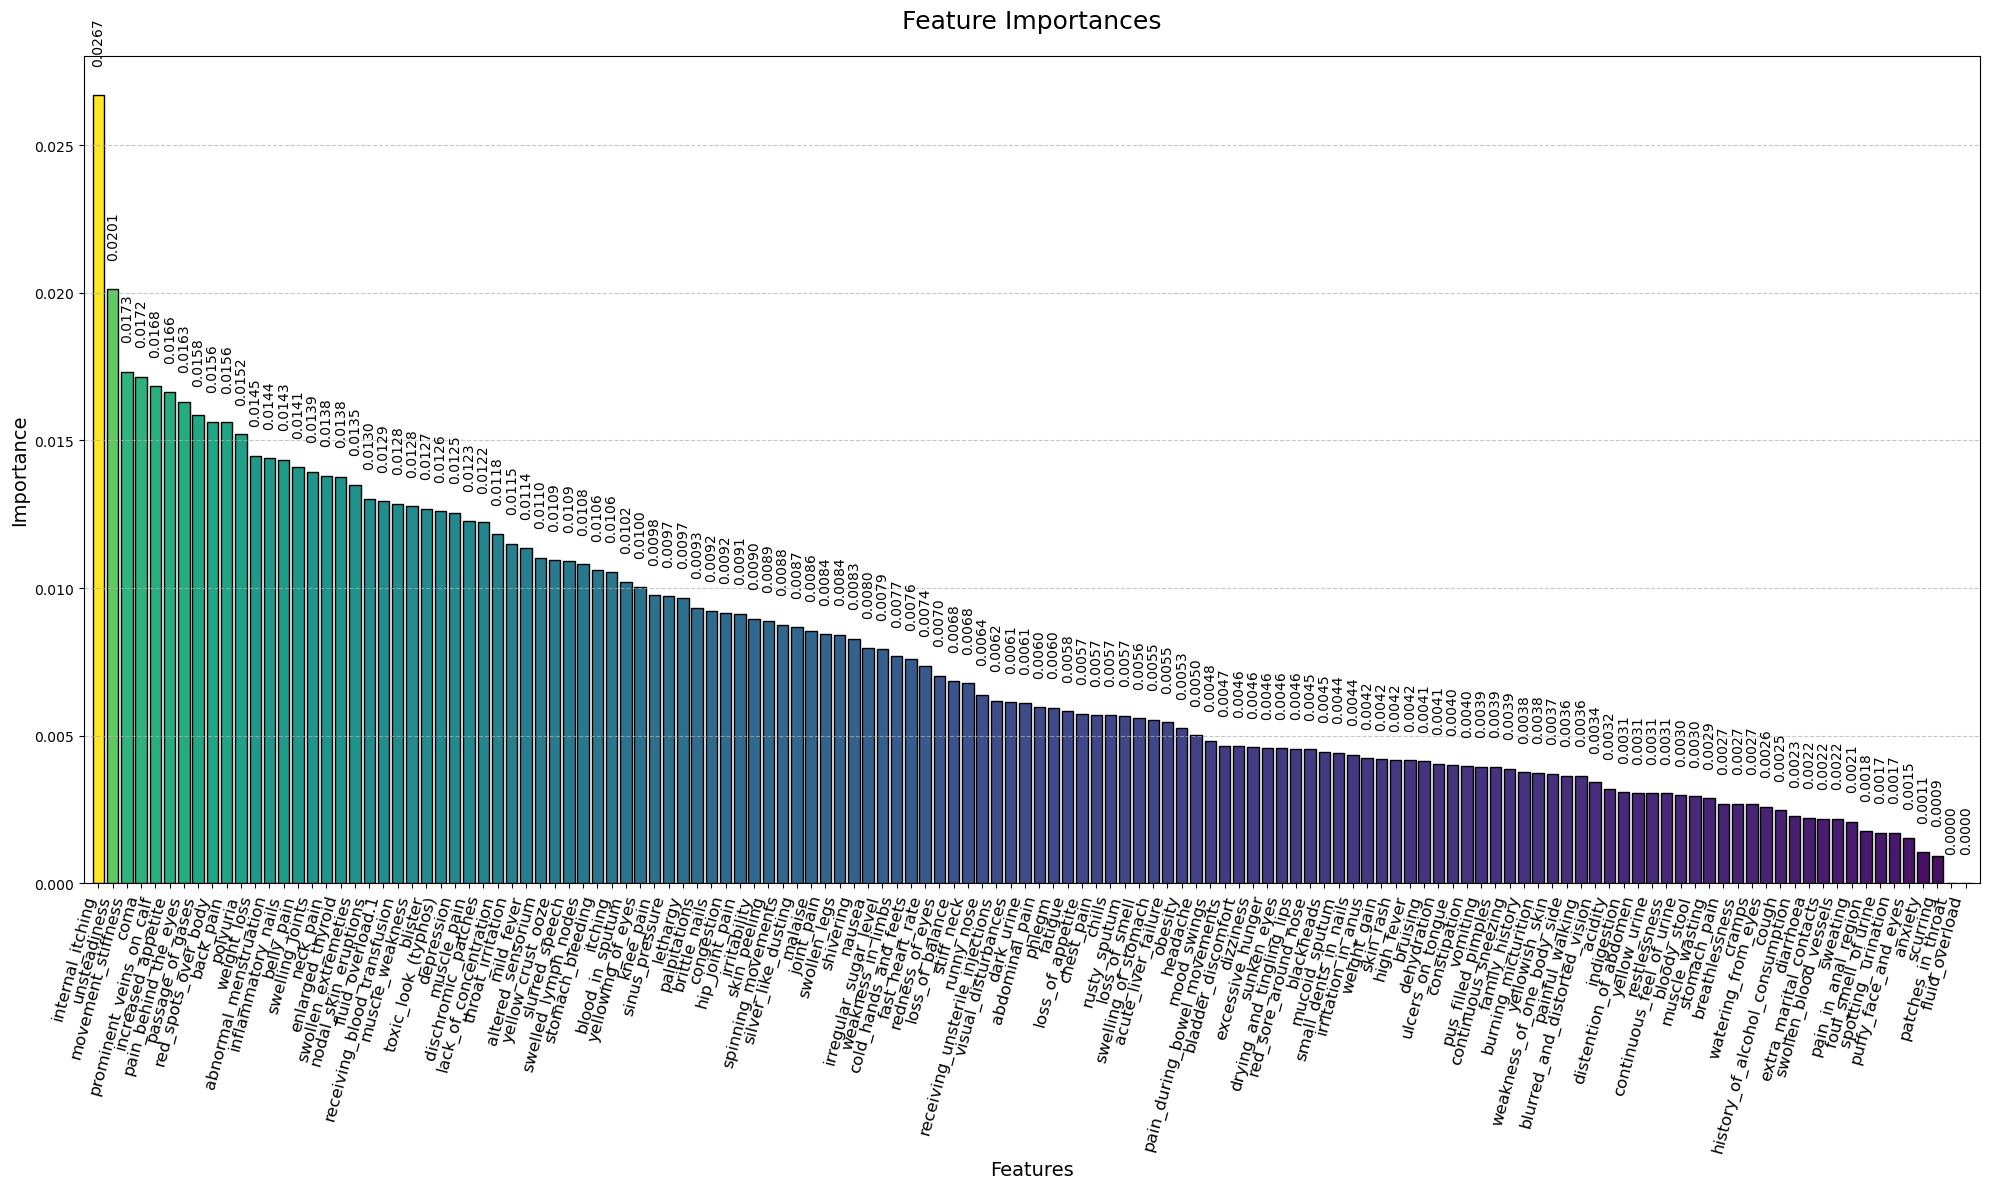

In [16]:
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Normalize importances for better visualization
importances_normalized = importances[indices] / np.max(importances[indices])

# Set up the plot with increased height to accommodate labels
plt.figure(figsize=(20, 12))
plt.title('Feature Importances', fontsize=18, pad=20)

# Use a color map for the bars
colors = plt.cm.viridis(importances_normalized)

# Plot the bar chart with a modern look
bars = plt.bar(range(X_train.shape[1]), importances[indices], color=colors, align='center', edgecolor='black')

# Improve x-ticks labels
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=75, ha='right', fontsize=12)

# Add labels to bars, positioning them carefully
for bar, value in zip(bars, importances[indices]):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.001, f'{value:.4f}', ha='center', fontsize=10, rotation=90, verticalalignment='bottom')

# Add grid lines and limits
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xlim([-1, X_train.shape[1]])
plt.ylim([0, 1.05 * max(importances)])

# Axis labels
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)

# Adjust layout to fit everything neatly
plt.tight_layout()
plt.show()

# Final Evaluation on Test Data

In [17]:
# Test the model on the test data
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

Test Accuracy: 0.9762
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00         1
                                   AIDS       1.00      1.00      1.00         1
                                   Acne       1.00      1.00      1.00         1
                    Alcoholic hepatitis       1.00      1.00      1.00         1
                                Allergy       1.00      1.00      1.00         1
                              Arthritis       1.00      1.00      1.00         1
                       Bronchial Asthma       1.00      1.00      1.00         1
                   Cervical spondylosis       1.00      1.00      1.00         1
                            Chicken pox       0.50      1.00      0.67         1
                    Chronic cholestasis       1.00      1.00      1.00         1
                            Common Cold       1.00      1.00      1.00         1
     

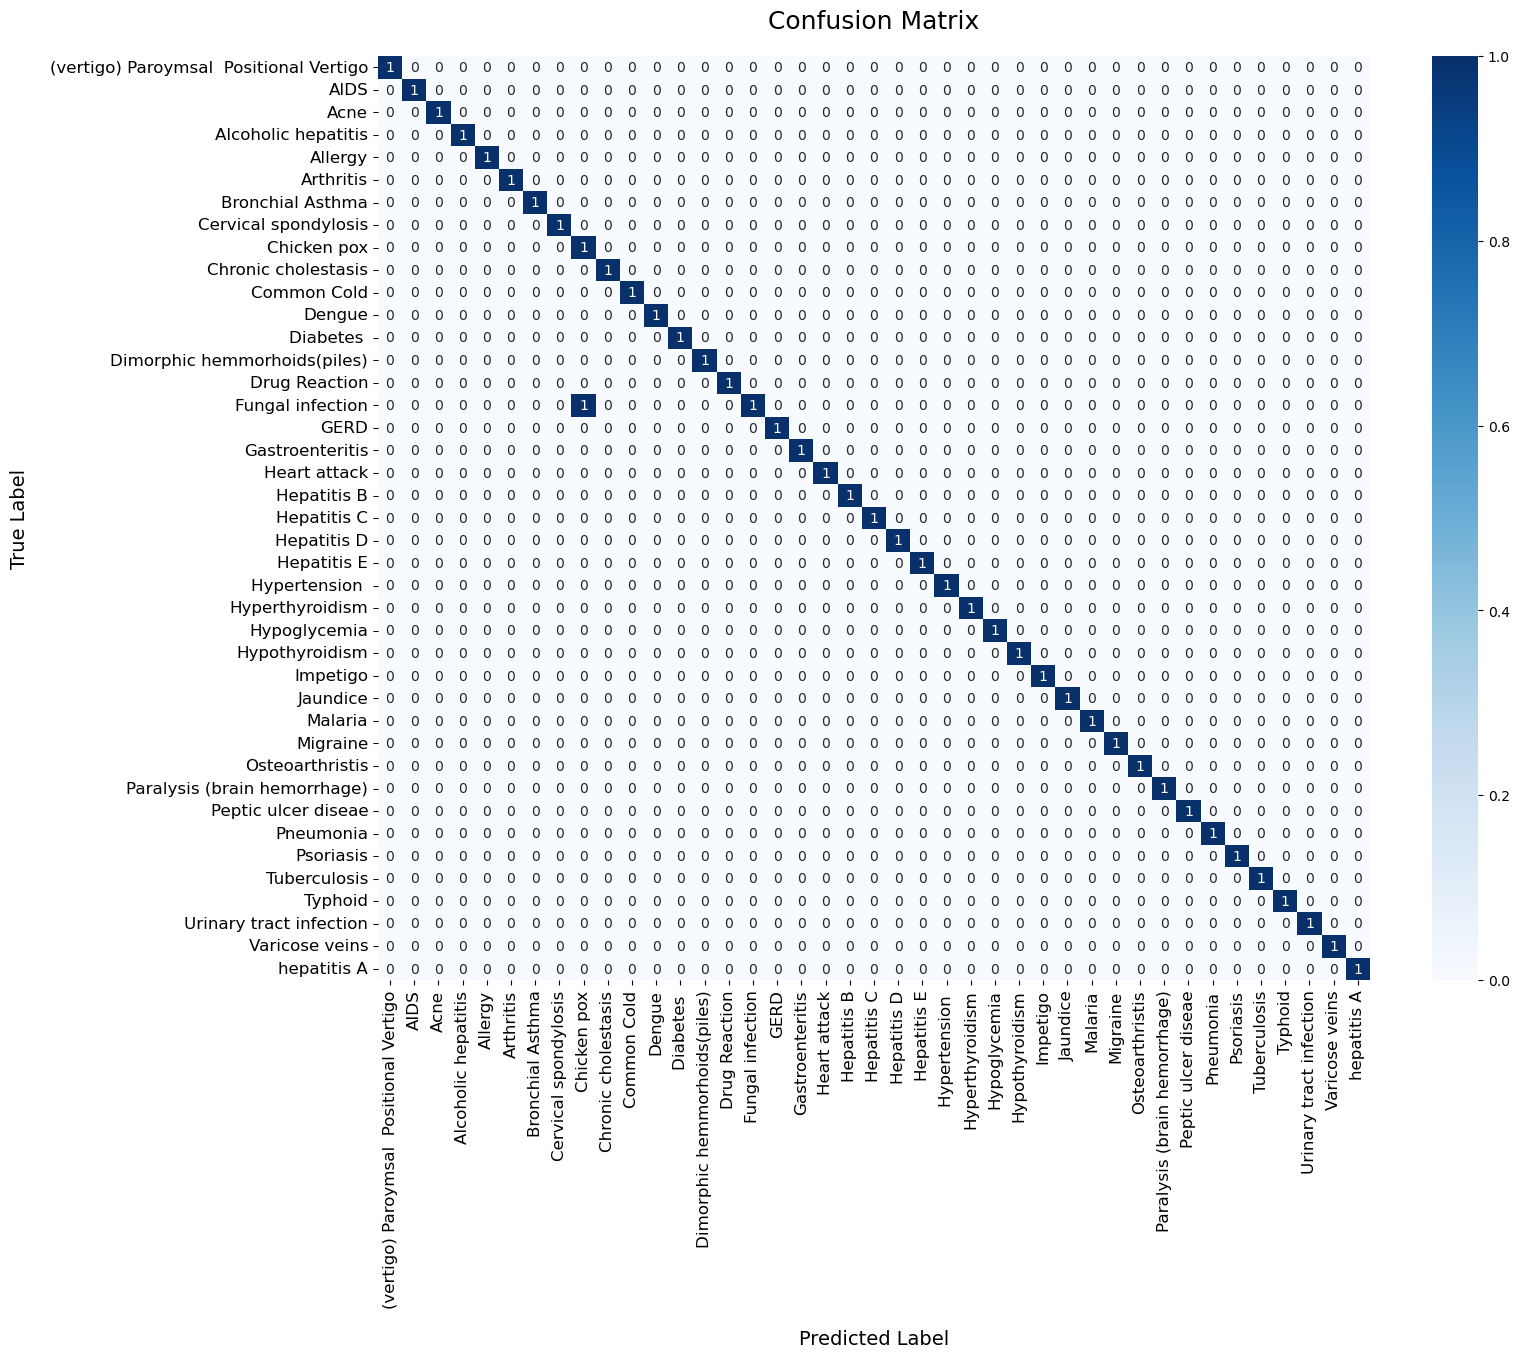

In [18]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=15)
plt.ylabel('True Label', fontsize=14, labelpad=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()